
# Assignment 3

This is a template notebook for Assignment 3.


## Install dependencies and initialization

In [1]:
# install dependencies: 
!pip install pyyaml==5.1 "pycocotools>=2.0.1"
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html


In [3]:
! module list

Currently Loaded Modulefiles:
 1) ENVIRONMENTS/RCG    4) LIB/CUDA/11.1                   7) login  
 2) use.own             5) LIB/CUDNN/8.0.5-CUDA11.1       
 3) LANG/PYTHON/3.8.7   6) TOOLS/PYTORCH/1.9.0-GPU-PY387  
>

In [4]:
!pwd # shows current directory
!ls  # shows all files in this directory
!nvidia-smi # shows the specs and the current status of the allocated GPU

/local-scratch/localhome/msw10/Desktop/Semester 2/Computer Vision/Assignments/Assignment 3
data  lab3.ipynb  output  project3_package.zip	rand.png
Mon Feb 21 17:02:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:01:00.0 Off |                  N/A |
| 41%   26C    P8    15W / 280W |    285MiB / 24217MiB |      0%      Default |
|                               |                      |                  N/A |
+--------------------

In [1]:
# import some common libraries
# from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os

import torch
print(torch.__version__)

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch

# import some common detectron2 utilities
import detectron2
import detectron2.data.transforms
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
setup_logger()

import matplotlib.pyplot as plt

1.9.0+cu111


In [2]:
# Make sure that GPU is available for your notebook. 
# Otherwise, you need to update the settungs in Runtime -> Change runtime type -> Hardware accelerator
torch.cuda.is_available()

True

In [ ]:
# You need to mount your google drive in order to load the data:
from google.colab import drive
drive.mount('/content/drive')
# Put all the corresponding data files in a data folder and put the data folder in a same directory with this notebook.
# Also create an output directory for your files such as the trained models and the output images.

In [3]:
# Define the location of current directory, which should contain data/train, data/test, and data/train.json.
# TODO: approx 1 line
BASE_DIR = '.'
OUTPUT_DIR = '{}/output'.format(BASE_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Part 1: Object Detection

### Data Loader

In [4]:
'''
# This function should return a list of data samples in which each sample is a dictionary. 
# Make sure to select the correct bbox_mode for the data
# For the test data, you only have access to the images, therefore, the annotations should be empty.
# Other values could be obtained from the image files.
# TODO: approx 35 lines
'''
def get_detection_data(set_name):
    data_dirs = '{}/data'.format(BASE_DIR)
    dataset = []
    already_added = []      # holds the image files which have already been "processed" or "added to the memory"

    if set_name == "train":
        with open(os.path.join(data_dirs, "train.json") , 'r') as jsonFile:
            rawdataset = json.load(jsonFile)

            for idx, value in enumerate(rawdataset):
                dataItem = {}
                filename = os.path.join(data_dirs, "train", value["file_name"])
                width, height = Image.open(filename).size[:2]

                obj = {
                    "bbox": value["bbox"],
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": value["segmentation"],
                    "category_id": 0
                }

                if filename in already_added:
                    dict_idx = already_added.index(filename)
                    dataset[dict_idx]["annotations"].append(obj)
                else:
                    dataItem["file_name"] = filename
                    already_added.append(filename)
                    dataItem["image_id"] = idx
                    dataItem["height"] = height
                    dataItem["width"] = width
                    dataItem["annotations"] = [obj]
                    dataset.append(dataItem)

    elif set_name == "test":
        for idx, filename in enumerate(os.listdir(os.path.join(data_dirs, "test"))):
            dataItem = {}
            width, height = Image.open(os.path.join(data_dirs, "test", filename)).size[:2]

            dataItem["file_name"] = os.path.join(data_dirs, "test", filename)
            dataItem["image_id"] = idx
            dataItem["height"] = height
            dataItem["width"] = width
            dataItem["annotations"] = []

            dataset.append(dataItem)
    return dataset

In [5]:
'''
# Remember to add your dataset to DatasetCatalog and MetadataCatalog
# Consdier "data_detection_train" and "data_detection_test" for registration
# You can also add an optional "data_detection_val" for your validation by spliting the training data
# TODO: approx 5 lines
'''
for d in ["train", "test"]:
    DatasetCatalog.register("data_detection_" + d, lambda d=d: get_detection_data(d))
    MetadataCatalog.get("data_detection_" + d).set(thing_classes=["plane"])
train_meta = MetadataCatalog.get("data_detection_train")
test_meta = MetadataCatalog.get("data_detection_test")

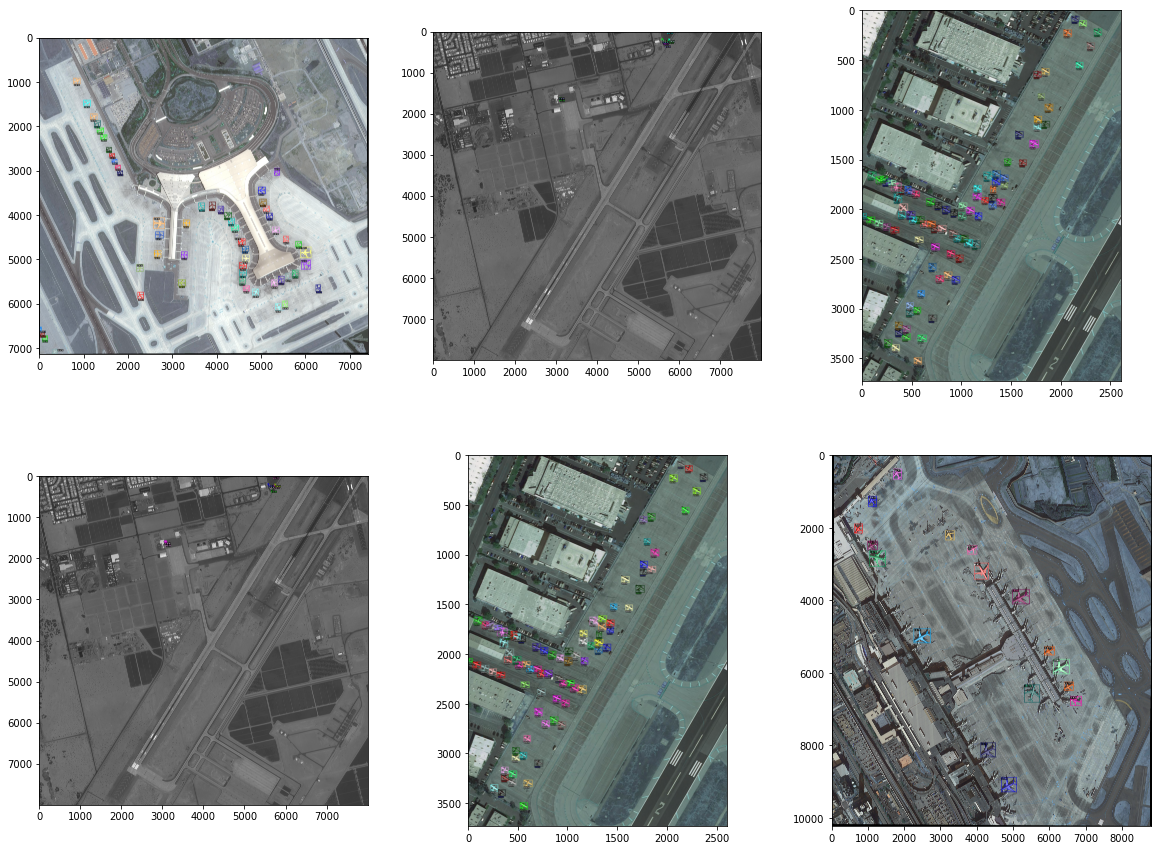

In [6]:
'''
# Visualize some samples using Visualizer to make sure that the function works correctly
# TODO: approx 5 lines
'''
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
random_train = [item for item in random.sample(DatasetCatalog.get("data_detection_train"), 6)]

for row in range(axs.shape[0]):
    for col in range(axs.shape[1]):
        image = cv2.imread(random_train[row+col]["file_name"])
        visualizer = Visualizer(image[:, :, ::-1], metadata=train_meta, scale=2)
        out = visualizer.draw_dataset_dict(random_train[row+col])
        axs[row][col].imshow(out.get_image()[:, :, ::-1])

### Set Configs

In [12]:
'''
# Set the configs for the detection part in here.
# TODO: approx 15 lines
'''
cfg = get_cfg()
cfg.OUTPUT_DIR = "{}/output/".format(BASE_DIR)

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("data_detection_train",)
cfg.DATASETS.TEST = ("data_detection_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = [] 

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1     # plane is the only class

### Training

In [8]:
'''
# Create a DefaultTrainer using the above config and train the model
# TODO: approx 5 lines
'''
class DetectionTrainer(DefaultTrainer):
    def train_loader(cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=[
            detectron2.data.transforms.resize((900, 900)),
            # detectron2.data.transforms.ResizeShortestEdge(1200, max_size = 2000),
            detectron2.data.transforms.RandomCrop("relative", (0.7, 0.7)),
            # detectron2.data.transforms.ResizeShortestEdge(800, max_size = 1500),
            detectron2.data.transforms.RandomBrightness(0.3, 1.5),
            detectron2.data.transforms.RandomFlip(),
            detectron2.data.transforms.RandomRotation([0, 360])
        ])
        return build_detection_train_loader(cfg, mapper=mapper)

trainer = DetectionTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/23 02:20:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/cvmfs/rcg.sfu.ca/sw/env/Ubuntu/20.04/amd64/LANG/PYTHON/3.8.7/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading pa

[02/23 02:20:19 d2.engine.train_loop]: Starting training from iteration 0


/cvmfs/rcg.sfu.ca/sw/env/Ubuntu/20.04/amd64/TOOLS/PYTORCH/1.9.0-GPU-PY387/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/cvmfs/rcg.sfu.ca/sw/env/Ubuntu/20.04/amd64/TOOLS/PYTORCH/1.9.0-GPU-PY387/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return 

[02/23 02:20:32 d2.utils.events]:  eta: 0:03:25  iter: 19  total_loss: 2.784  loss_cls: 0.6833  loss_box_reg: 0.4087  loss_rpn_cls: 1.342  loss_rpn_loc: 0.3492  time: 0.5170  data_time: 0.3850  lr: 9.7405e-06  max_mem: 5405M
[02/23 02:20:40 d2.utils.events]:  eta: 0:02:39  iter: 39  total_loss: 1.9  loss_cls: 0.627  loss_box_reg: 0.2761  loss_rpn_cls: 0.5549  loss_rpn_loc: 0.3528  time: 0.4575  data_time: 0.1673  lr: 1.9731e-05  max_mem: 5405M
[02/23 02:20:50 d2.utils.events]:  eta: 0:02:48  iter: 59  total_loss: 1.561  loss_cls: 0.5082  loss_box_reg: 0.249  loss_rpn_cls: 0.3097  loss_rpn_loc: 0.3905  time: 0.4700  data_time: 0.2569  lr: 2.972e-05  max_mem: 5405M
[02/23 02:21:02 d2.utils.events]:  eta: 0:02:40  iter: 79  total_loss: 1.144  loss_cls: 0.3821  loss_box_reg: 0.2453  loss_rpn_cls: 0.2535  loss_rpn_loc: 0.2682  time: 0.5018  data_time: 0.3535  lr: 3.9711e-05  max_mem: 5405M
[02/23 02:21:12 d2.utils.events]:  eta: 0:02:36  iter: 99  total_loss: 1.258  loss_cls: 0.389  loss_bo

### Evaluation and Visualization

In [9]:
'''
# After training the model, you need to update cfg.MODEL.WEIGHTS
# Define a DefaultPredictor
'''
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

predictor = DefaultPredictor(cfg)

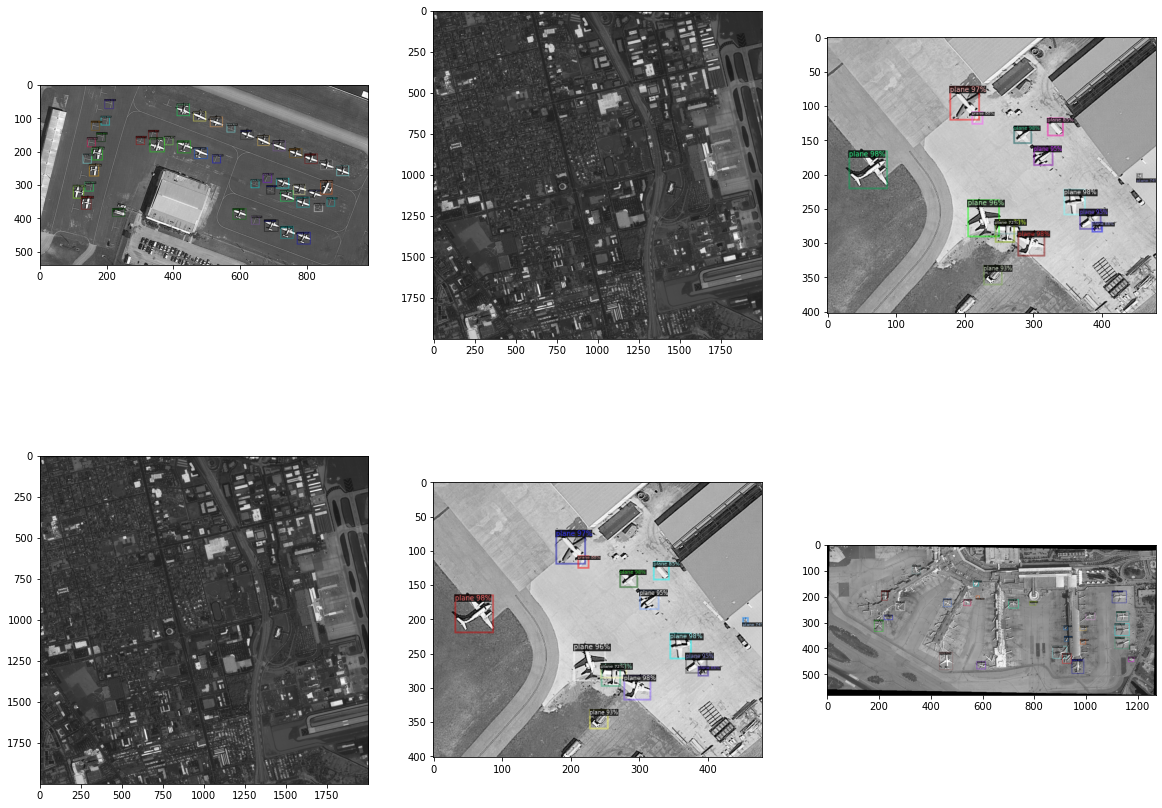

In [10]:
'''
# Visualize the output for 3 random test samples
# TODO: approx 10 lines
'''
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
random_test = [item for item in random.sample(DatasetCatalog.get("data_detection_test"), 6)]

for row in range(axs.shape[0]):
    for col in range(axs.shape[1]):
        image = cv2.imread(random_test[row+col]["file_name"])
        outputs = predictor(image)
        visualizer = Visualizer(image[:, :, ::-1],
                                metadata=test_meta,
                                scale=0.5,
                                instance_mode=ColorMode.IMAGE_BW
        )
        out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
        axs[row][col].imshow(out.get_image()[:, :, ::-1])

In [13]:
'''
# Use COCOEvaluator and build_detection_train_loader
# You can save the output predictions using inference_on_dataset
# TODO: approx 5 lines
'''

evaluator = COCOEvaluator("data_detection_test", output_dir=cfg.OUTPUT_DIR)
test_loader = build_detection_test_loader(cfg, "data_detection_test")
print(inference_on_dataset(trainer.model, test_loader, evaluator))

[02/23 02:28:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/23 02:28:41 d2.data.common]: Serializing 72 elements to byte tensors and concatenating them all ...
[02/23 02:28:41 d2.data.common]: Serialized dataset takes 0.01 MiB
[02/23 02:28:41 d2.evaluation.evaluator]: Start inference on 72 batches
[02/23 02:28:44 d2.evaluation.evaluator]: Inference done 11/72. Dataloading: 0.1694 s/iter. Inference: 0.0529 s/iter. Eval: 0.0002 s/iter. Total: 0.2225 s/iter. ETA=0:00:13
[02/23 02:28:49 d2.evaluation.evaluator]: Inference done 32/72. Dataloading: 0.1875 s/iter. Inference: 0.0531 s/iter. Eval: 0.0002 s/iter. Total: 0.2409 s/iter. ETA=0:00:09
[02/23 02:28:54 d2.evaluation.evaluator]: Inference done 50/72. Dataloading: 0.2074 s/iter. Inference: 0.0521 s/iter. Eval: 0.0002 s/iter. Total: 0.2597 s/iter. ETA=0:00:05
[02/23 02:29:00 d2.evaluation.evaluator]: Inference done 70

### Improvements

For this part, you can bring any improvement which you have by adding new input parameters to the previous functions or defining new functions and variables.

In [ ]:
'''
# Bring any changes and updates regarding the improvement in here
'''


## Part 2: Semantic Segmentation

### Data Loader

In [14]:
'''
# Write a function that returns the cropped image and corresponding mask regarding the target bounding box
# idx is the index of the target bbox in the data
# high-resolution image could be passed or could be load from data['file_name']
# You can use the mask attribute of detectron2.utils.visualizer.GenericMask 
# to convert the segmentation annotations to binary masks
# TODO: approx 10 lines
'''
from detectron2.utils.visualizer import GenericMask

def get_instance_sample(data, idx, img=None):
    width = data["width"]
    height = data["height"]

    mask = data["annotations"][idx]["segmentation"]
    bbx, bby, bbw, bbh = data["annotations"][idx]["bbox"]

    obj_img = img[round(bby):round(bby + bbh), round(bbx):round(bbx + bbw)]

    obj_mask = np.array(GenericMask(mask, height, width).mask)
    obj_mask = obj_mask[round(bby):round(bby + bbh), round(bbx):round(bbx + bbw)]

    return obj_img, obj_mask

In [ ]:
'''
# We have provided a template data loader for your segmentation training
# You need to complete the __getitem__() function before running the code
# You may also need to add data augmentation or normalization in here
'''

class PlaneDataset(Dataset):
    def __init__(self, set_name, data_list):
        self.transforms = transforms.Compose([
            transforms.ToTensor(), # Converting the image to tensor and change the image format (Channels-Last => Channels-First)
        ])
        self.set_name = set_name
        self.data = data_list
        self.instance_map = []
        for i, d in enumerate(self.data):
            for j in range(len(d['annotations'])):
                self.instance_map.append([i,j])

    '''
    # you can change the value of length to a small number like 10 for debugging of your training procedure and overfeating
    # make sure to use the correct length for the final training
    '''
    def __len__(self):
        return len(self.instance_map)

    def numpy_to_tensor(self, img, mask):
        if self.transforms is not None:
            img = self.transforms(img)
            img = torch.tensor(img, dtype=torch.float)
            mask = torch.tensor(mask, dtype=torch.float)
            return img, mask

    '''
    # Complete this part by using get_instance_sample function
    # make sure to resize the img and mask to a fixed size (for example 128*128)
    # you can use "interpolate" function of pytorch or "numpy.resize"
    # TODO: 5 lines
    '''
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            idx = self.instance_map[idx]
            data = self.data[idx[0]]
            

            return img, mask

    def get_plane_dataset(set_name='train', batch_size=2):
        my_data_list = DatasetCatalog.get("data_detection_{}".format(set_name))
        dataset = PlaneDataset(set_name, my_data_list)
        loader = DataLoader(dataset, batch_size=batch_size, num_workers=4,
                            pin_memory=True, shuffle=True)
        return loader, dataset

### Network

In [ ]:
'''
# convolution module as a template layer consists of conv2d layer, batch normalization, and relu activation
'''
class conv(nn.Module):
    def __init__(self, in_ch, out_ch, activation=True):
        super(conv, self).__init__()
        if(activation):
            self.layer = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        else:
            self.layer = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1)  
            )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# downsampling module equal to a conv module followed by a max-pool layer
'''
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.layer = nn.Sequential(
            conv(in_ch, out_ch),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# upsampling module equal to a upsample function followed by a conv module
'''
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, 2, stride=2)

        self.conv = conv(in_ch, out_ch)

    def forward(self, x):
        y = self.up(x)
        y = self.conv(y)
        return y

'''
# the main model which you need to complete by using above modules.
# you can also modify the above modules in order to improve your results.
'''
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Encoder
        
        self.input_conv = conv(3, 4)
        self.down = down(4, 8)
        
        # Decoder
        
        self.up = up(8, 4)
        self.output_conv = conv(4, 1, False) # ReLu activation is removed to keep the logits for the loss function
        

    def forward(self, input):
        y = self.input_conv(input)
        y = self.down(y)
        y = self.up(y)
        output = self.output_conv(y)
        return output

### Training

In [ ]:
'''
# The following is a basic training procedure to train the network
# You need to update the code to get the best performance
# TODO: approx ? lines
'''

# Set the hyperparameters
num_epochs = 5
batch_size = 4
learning_rate = 0.01
weight_decay = 1e-5

model = MyModel() # initialize the model
model = model.cuda() # move the model to GPU
loader, _ = get_plane_dataset('train', batch_size) # initialize data_loader
crit = nn.BCEWithLogitsLoss() # Define the loss function
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Initialize the optimizer as SGD

# start the training procedure
for epoch in range(num_epochs):
    total_loss = 0
    for (img, mask) in tqdm(loader):
        img = torch.tensor(img, device=torch.device('cuda'), requires_grad = True)
        mask = torch.tensor(mask, device=torch.device('cuda'), requires_grad = True)
        pred = model(img)
        loss = crit(pred, mask)
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.cpu().data
    print("Epoch: {}, Loss: {}".format(epoch, total_loss/len(loader)))
    torch.save(model.state_dict(), '{}/output/{}_segmentation_model.pth'.format(BASE_DIR, epoch))

'''
# Saving the final model
'''
torch.save(model.state_dict(), '{}/output/final_segmentation_model.pth'.format(BASE_DIR))


### Evaluation and Visualization

In [ ]:
'''
# Before starting the evaluation, you need to set the model mode to eval
# You may load the trained model again, in case if you want to continue your code later
# TODO: approx 15 lines
'''
batch_size = 8
model = MyModel().cuda()
model.load_state_dict(torch.load('{}/output/final_segmentation_model.pth'.format(BASE_DIR)))
model = model.eval() # chaning the model to evaluation mode will fix the bachnorm layers
loader, dataset = get_plane_dataset('train', batch_size)

total_iou = 0
for (img, mask) in tqdm(loader):
    with torch.no_grad():
        img = img.cuda()
        mask = mask.cuda()
        mask = torch.unsqueeze(mask,1)
        pred = model(img)
        
        '''
        ## Complete the code by obtaining the IoU for each img and print the final Mean IoU
        '''
    

print("\n #images: {}, Mean IoU: {}".format(_, _))

In [ ]:
'''
# Visualize 3 sample outputs
# TODO: approx 5 lines
'''


## Part 3: Instance Segmentation

In this part, you need to obtain the instance segmentation results for the test data by using the trained segmentation model in the previous part and the detection model in Part 1.

### Get Prediction

In [ ]:
'''
# Define a new function to obtain the prediction mask by passing a sample data
# For this part, you need to use all the previous parts (predictor, get_instance_sample, data preprocessings, etc)
# It is better to keep everything (as well as the output of this funcion) on gpu as tensors to speed up the operations.
# pred_mask is the instance segmentation result and should have different values for different planes.
# TODO: approx 35 lines
'''

def get_prediction_mask(data):

  return img, gt_mask, pred_mask # gt_mask could be all zero when the ground truth is not given.


### Visualization and Submission

In [ ]:
'''
# Visualise the output prediction as well as the GT Mask and Input image for a sample input
# TODO: approx 10 lines
'''



In [ ]:
'''
# ref: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# https://www.kaggle.com/c/airbus-ship-detection/overview/evaluation
'''
def rle_encoding(x):
    '''
    x: pytorch tensor on gpu, 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = torch.where(torch.flatten(x.long())==1)[0]
    if(len(dots)==0):
      return []
    inds = torch.where(dots[1:]!=dots[:-1]+1)[0]+1
    inds = torch.cat((torch.tensor([0], device=torch.device('cuda'), dtype=torch.long), inds))
    tmpdots = dots[inds]
    inds = torch.cat((inds, torch.tensor([len(dots)], device=torch.device('cuda'))))
    inds = inds[1:] - inds[:-1]
    runs = torch.cat((tmpdots, inds)).reshape((2,-1))
    runs = torch.flatten(torch.transpose(runs, 0, 1)).cpu().data.numpy()
    return ' '.join([str(i) for i in runs])

In [ ]:
'''
# You need to upload the csv file on kaggle
# The speed of your code in the previous parts highly affects the running time of this part
'''

preddic = {"ImageId": [], "EncodedPixels": []}

'''
# Writing the predictions of the training set
'''
my_data_list = DatasetCatalog.get("data_detection_{}".format('train'))
for i in tqdm(range(len(my_data_list)), position=0, leave=True):
  sample = my_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for index in inds:
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index)
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

'''
# Writing the predictions of the test set
'''

my_data_list = DatasetCatalog.get("data_detection_{}".format('test'))
for i in tqdm(range(len(my_data_list)), position=0, leave=True):
  sample = my_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for j, index in enumerate(inds):
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index).double()
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

pred_file = open("{}/pred.csv".format(BASE_DIR), 'w')
pd.DataFrame(preddic).to_csv(pred_file, index=False)
pred_file.close()


## Part 4: Mask R-CNN

For this part you need to follow a same procedure to part 2 with the configs of Mask R-CNN, other parts are generally the same as part 2.

### Data Loader

### Network

### Training

### Evaluation and Visualization